# vnf

In [1]:
from numbers import Real

import numpy as np
import numpy.typing as npt


def _energy_decay(alpha: float, number_of_impulses: int) -> float:
    """
    Given the alpha value and the number of impulses, what is the target decay?
    L_db = 20 log_10 (exp(-alpha M))
    """
    return 20.0 * np.log10(np.exp(-alpha * number_of_impulses))


def _inverse_energy_decay(target_decay: float, number_of_impulses: int) -> float:
    """
    Given the energy decay and the number of impulses, what is the alpha?
    """
    return (-1 / number_of_impulses) * np.log(np.power(10, target_decay / 20))


def _make_decaying_sample(size: int, alpha: float) -> npt.NDArray[np.float32]:
    rng = np.random.default_rng()
    samples = np.zeros((size,), dtype=np.float32)
    for i in range(size):
        samples[i] = np.exp(-alpha * i) * rng.choice([1, -1]) # * rng.uniform(0.5, 2)
    return samples


def velvet_noise(sample_rate: Real,
                 filter_length_ms: Real,
                 number_of_impulses: int,
                 target_decay: float) -> npt.NDArray[np.float32]:
    """
    Create a velvet noise discrete-time signal.
    :param sample_rate: the sample rate of the returned signal
    :param filter_length_ms: the total milliseconds of the returned signal
    :param number_of_impulses: the number of non-zero samples in the returned noise
    :param target_decay: the amount of decay applied on non-zero samples
    :return: a velvet noise. The returned data bit-rate is 32-bit
    """

    # Parameter value and type check
    if sample_rate <= 0:
        raise ValueError(f'The sample rate should be a positive real number. Got {sample_rate}')
    if filter_length_ms <= 0:
        raise ValueError(f'The filter length should be a positive real number. Got {filter_length_ms}')
    if number_of_impulses <= 0:
        raise ValueError(f'The total number of impulses cannot be non-positive. Got {number_of_impulses}')
    if target_decay > 0:
        raise ValueError(f'The target decay is expected to be negative. Got {target_decay}')

    rng = np.random.default_rng()
    filter_size = np.int32(sample_rate * filter_length_ms / 1000)

    velvet_noise_return = np.zeros((filter_size,), dtype=np.float32)

    alpha = _inverse_energy_decay(target_decay, number_of_impulses)

    indices = np.sort(rng.choice(filter_size, size=(number_of_impulses,), replace=False, shuffle=False))
    decaying_sample = _make_decaying_sample(number_of_impulses, alpha)
    velvet_noise_return[indices] = decaying_sample

    return velvet_noise_return

# plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def plot_freqz(w, h):
    """
    A helper function to acquire a plot directly from `scipy.signal.freqz` function.
    """
    fig, ax1 = plt.subplots()

    ax1.set_title('Digital filter frequency response')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')


def no_output(*args):
    pass

In [5]:
import matplotlib.pyplot as plt
from scipy import signal

The velvet noise proposed by the study has the following parameters:
* $f_s$: the sample rate
* $\rho$: the density of non-zero impulses
* $\alpha$: the decay rate

And when it comes to production, we use these parameters:
* $L_s$: the length of the filter in milliseconds
* $M$: the number of impulses (non-zero samples)
* $L_\text{dB}$: the target decay

We also need the sample rate $f_s$. 

In [3]:
sr = 44100.0

We create our first velvet noise filter with the following parameters:
- $L_s$, the length of the filter in milliseconds, to be $10$
- $M$, the number of impulses, to be $8$
- $L_\text{dB}$, the target decay, to be $-5\text{dB}$

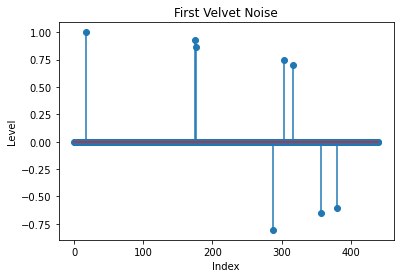

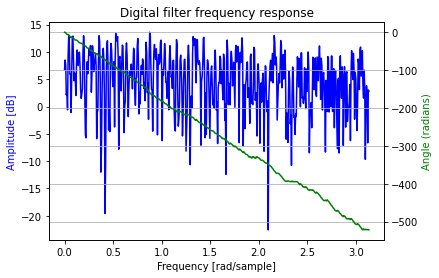

In [6]:
vn1 = velvet_noise(sr, 10, 8, -5)
plt.stem(vn1)
plt.title('First Velvet Noise')
plt.xlabel('Index')
plt.ylabel('Level')
plt.show()
plot_freqz(*signal.freqz(vn1))